<a href="https://colab.research.google.com/github/ishita-saraswat/ishita-saraswat/blob/main/Mean_Variance_Optimisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 KB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 KB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 KB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 50.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 KB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 8.1 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.25.1
    Uninstalling requests-2.25.1:
      Successfully uninstalled requests-2.25.1
  Attempting uninstall: html5lib
    Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
   

In [ ]:
import numpy as np
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt 
import scipy.optimize as optimization

In [ ]:
stocks=['MSFT', 'TSLA', 'AMZN']
start_date= '2013-01-01'
end_date='2019-01-01'

In [ ]:
# on average there are 252 trading days in a year
NUM_TRADING_DAYS = 252
# we will generate random w (different portfolios)
NUM_PORTFOLIOS = 10000

In [ ]:
#downloads stock data for a given list of stocks over a specified time period
def download_data():
  #name of the stock as the key and stock values as the values 
  stock_data={} #empty dictionary which will store data 

  for stock in stocks:
    ticker=yf.Ticker(stock)
    stock_data[stock]=ticker.history(start= start_date, end= end_date)['Close']
  
  return pd.DataFrame(stock_data)


#plots the stock data in a line chart 
def show_data(data):
  data.plot(figsize=(10,5))
  plt.show()


#Calculates the log returns (to normalize the stock data so that 
#it can be compared across different stocks) of the stock data 
def calculate_return(data):
    # NORMALIZATION - to measure all variables in comparable metric
    log_return = np.log(data / data.shift(1))
    return log_return[1:]


#prints the mean and covariance of the log returns 
def show_statistics(returns):
    # instead of daily metrics we are after annual metrics
    # mean of annual return
    print(returns.mean() * NUM_TRADING_DAYS)
    print(returns.cov() * NUM_TRADING_DAYS)



#calculates and prints the expected mean (return) and volatility 
#(standard deviation) of a portfolio with a given set of weights.
def show_mean_variance(returns, weights):
    # we are after the annual return
    portfolio_return = np.sum(returns.mean() * weights) * NUM_TRADING_DAYS
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov()
                                                            * NUM_TRADING_DAYS, weights)))
    print("Expected portfolio mean (return): ", portfolio_return)
    print("Expected portfolio volatility (standard deviation): ", portfolio_volatility)



#plots the expected return and volatility of a set of portfolios in a 
#scatter plot. The color of each point represents the Sharpe ratio of
#the portfolio.
def show_portfolios(returns, volatilities):
    plt.figure(figsize=(10, 6))
    plt.scatter(volatilities, returns, c=returns / volatilities, marker='o')
    plt.grid(True)
    plt.xlabel('Expected Volatility')
    plt.ylabel('Expected Return')
    plt.colorbar(label='Sharpe Ratio')
    plt.show()

#generates a set of random portfolios and returns their weights, 
#expected returns, and expected volatilities.
def generate_portfolios(returns):
    portfolio_means = []
    portfolio_risks = []
    portfolio_weights = []

    for _ in range(NUM_PORTFOLIOS):
        w = np.random.random(len(stocks))
        w /= np.sum(w)
        portfolio_weights.append(w)
        portfolio_means.append(np.sum(returns.mean() * w) * NUM_TRADING_DAYS)
        portfolio_risks.append(np.sqrt(np.dot(w.T, np.dot(returns.cov()
                                                          * NUM_TRADING_DAYS, w))))

    return np.array(portfolio_weights), np.array(portfolio_means), np.array(portfolio_risks)

#calculates and returns the expected return, volatility, and 
#Sharpe ratio of a portfolio with a given set of weights.
def statistics(weights, returns):
    portfolio_return = np.sum(returns.mean() * weights) * NUM_TRADING_DAYS
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov()
                                                            * NUM_TRADING_DAYS, weights)))
    return np.array([portfolio_return, portfolio_volatility,
                     portfolio_return / portfolio_volatility])
    #sharpe ratio = portfolio_return / portfolio_volatility


# scipy optimize module can find the minimum of a given function
# the maximum of a f(x) is the minimum of -f(x)
def min_function_sharpe(weights, returns):
    return -statistics(weights, returns)[2]


# f(x)=0  is the function to minimize
def optimize_portfolio(weights, returns):
    # the sum of weights is 1
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    # the weights can be 1 at most: 1 when 100% of money is invested into a single stock
    bounds = tuple((0, 1) for _ in range(len(stocks)))
    return optimization.minimize(fun=min_function_sharpe, x0=weights[0], args=returns
                                 , method='SLSQP', bounds=bounds, constraints=constraints)


def print_optimal_portfolio(optimum, returns):
    print("Optimal portfolio: ", optimum['x'].round(3))
    print("Expected return, volatility and Sharpe ratio: ",
          statistics(optimum['x'].round(3), returns))


def show_optimal_portfolio(opt, rets, portfolio_rets, portfolio_vols):
    plt.figure(figsize=(10, 6))
    plt.scatter(portfolio_vols, portfolio_rets, c=portfolio_rets / portfolio_vols, marker='o')
    plt.grid(True)
    plt.xlabel('Expected Volatility')
    plt.ylabel('Expected Return')
    plt.colorbar(label='Sharpe Ratio')
    plt.plot(statistics(opt['x'], rets)[1], statistics(opt['x'], rets)[0], 'g*', markersize=20.0)
    plt.show()



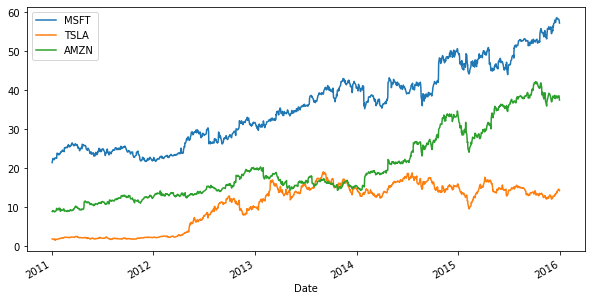

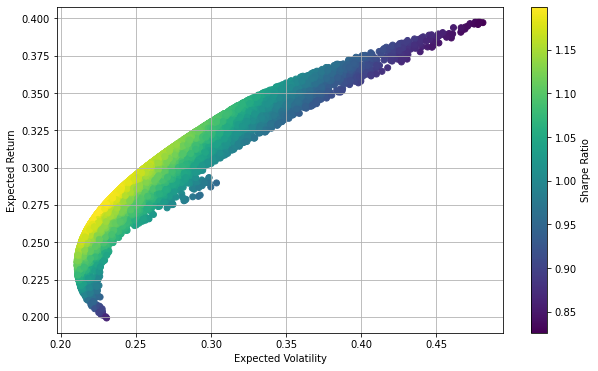

Optimal portfolio:  [0.422 0.202 0.377]
Expected return, volatility and Sharpe ratio:  [0.27341583 0.22798662 1.19926262]


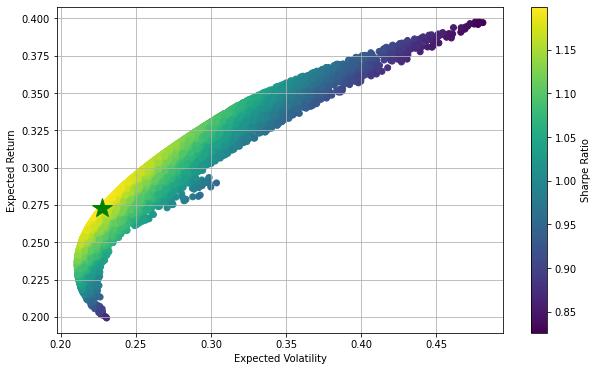

In [ ]:
if __name__ == '__main__':
    dataset = download_data()
    show_data(dataset)
    log_daily_returns = calculate_return(dataset)
    #show_statistics(log_daily_returns)

    pweights, means, risks = generate_portfolios(log_daily_returns)
    show_portfolios(means, risks)
    optimum = optimize_portfolio(pweights, log_daily_returns)
    print_optimal_portfolio(optimum, log_daily_returns)
    show_optimal_portfolio(optimum, log_daily_returns, means, risks)